# -- ANÁLISIS DE PREFERENCIAS MUSICALES A NIVEL GLOBAL --

### OBJETIVO: 
- Establecer una metodologia para extraer patrones de escucha y agrupar países según sus similitudes en consumo musical.

### CONSIDERACIONES:
- Se tomará como base una tabla con las tendencias de escucha de cada país segun estilo musical, si bien este estudio es aplicable a cualquier otro tipo de consumo se simplifica con fines educativos.

### PLAN:
1) Carga y exploración de datos
2) Preparación y Entrenamiento de datos para Machine Learning
    - KMeans
    - DBSCAN
    - Cluster jerárquico
    - PCA
    - t-SNE
3) Interpretación de resultados y Conclusiones

# 1.- CARGA Y EXPLORACIÓN DE DATOS

### 1.1.- IMPORTACIÓN DE LIBRERÍAS

In [1]:
import numpy as np
import pandas as pd 
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE

### 1.2.- CARGA DE DATOS

In [2]:
# Carga de datos

datos = "C:/Users/JoséDelCampo/OneDrive - rmesanalytics.com/Documentos/GITHUB-JIDC-DATASCIENCE/JoseDelCampo-Portfolio/dataset_generos_musicales.csv"
df = pd.read_csv(datos)
df.head()

,País,Pop,Rock,Hip-Hop,Electrónica,Clásica,Jazz,Reguetón,Metal
0,Chile,71,22,79,61,70,58,79,69
1,EEUU,34,41,40,79,74,37,90,23
2,México,91,72,52,99,83,23,63,21
3,Corea,80,21,95,34,22,79,27,25
4,Japón,40,49,77,81,70,33,66,73


### 1.3.- ANÁLISIS EXPLORATORIO DE DATOS

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   País         8 non-null      object
 1   Pop          8 non-null      int64 
 2   Rock         8 non-null      int64 
 3   Hip-Hop      8 non-null      int64 
 4   Electrónica  8 non-null      int64 
 5   Clásica      8 non-null      int64 
 6   Jazz         8 non-null      int64 
 7   Reguetón     8 non-null      int64 
 8   Metal        8 non-null      int64 
dtypes: int64(8), object(1)
memory usage: 708.0+ bytes


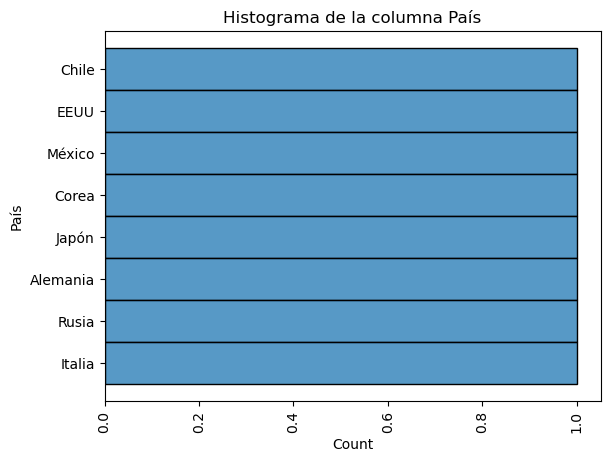

In [4]:
sns.histplot(data=df, y='País')
plt.title('Histograma de la columna País')
plt.xticks(rotation=90)
plt.show()

OBSERVACIONES:
- Hay 8 variables numericas y 1 categorica.
- La variable categorica tiene comportamiento de ID, por lo que no suma dentro de los estudios

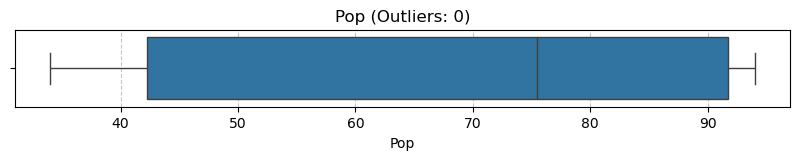

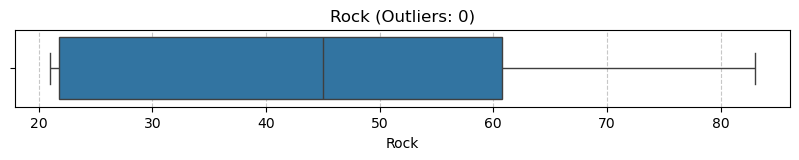

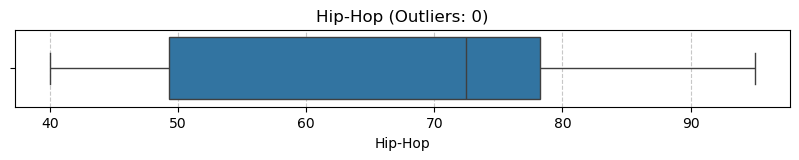

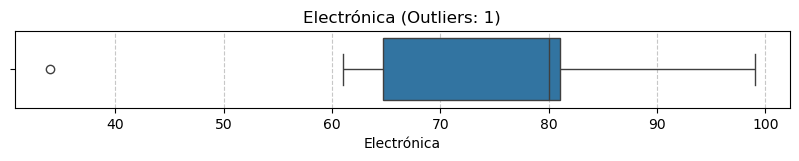

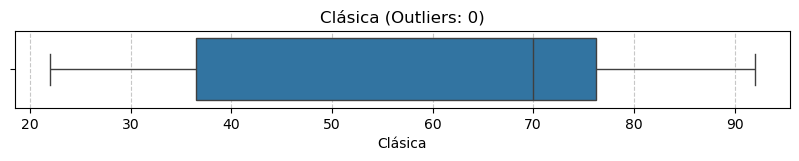

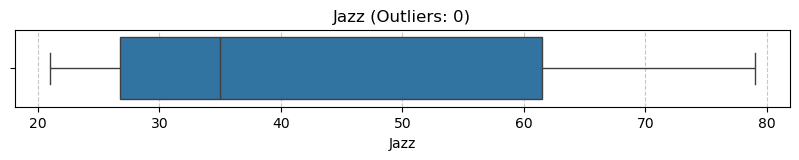

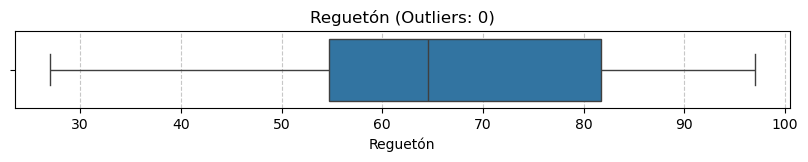

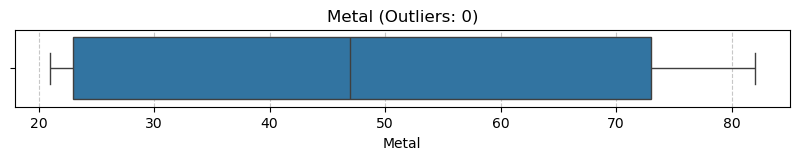

In [5]:
# Explorando outliers

for i in df.select_dtypes(include=['float64', 'int64']).columns:
    # Contador de Outliers
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    outliers = df[(df[i] < lower_limit) | (df[i] > upper_limit)][i]
    num_outliers = outliers.count()
    
    # Graficar boxplot
    plt.figure(figsize=(10, 1))
    sns.boxplot(data=df, x=df[i])
    plt.title(f"{i} (Outliers: {num_outliers})")
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

OBSERVACIONES:
- Solo hay 1 outlier en música electronica, se eliminará ya que cambiar su valor por otro en un dataset tan pequeño no seria representativo para el pais que representa

<Figure size 1000x1000 with 0 Axes>

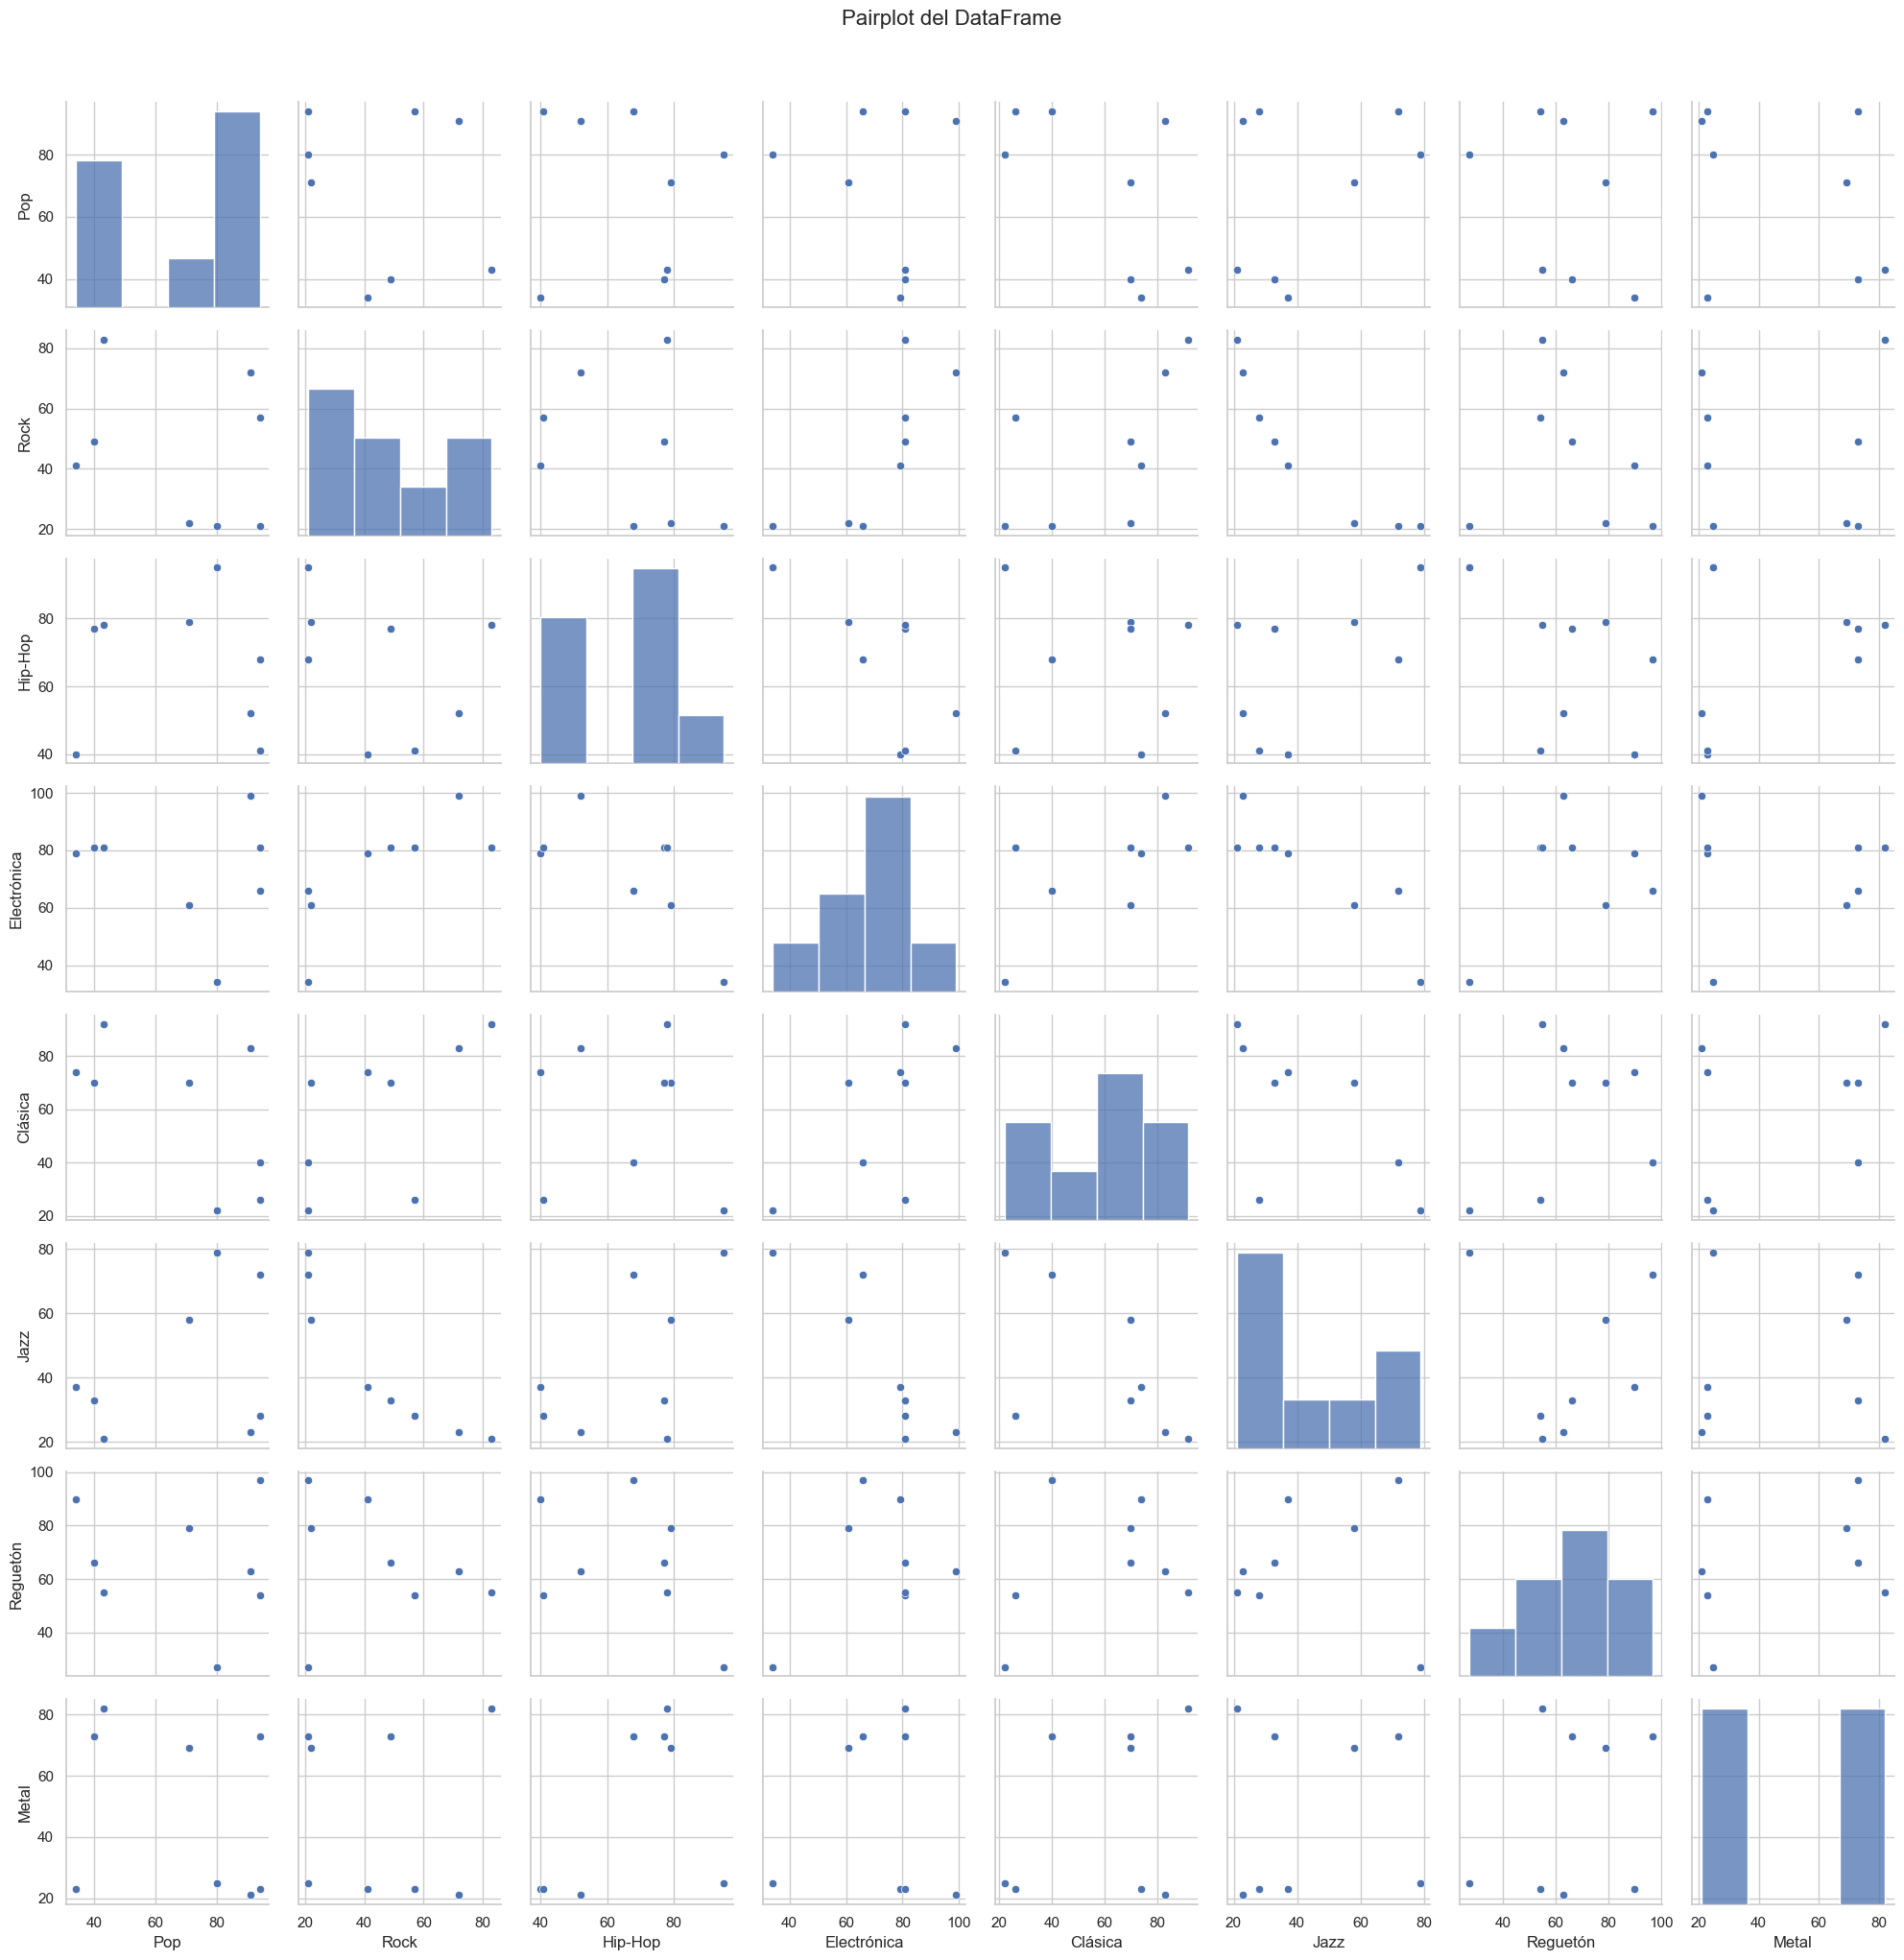

In [6]:
# Pairplot de los datos

sns.set(style="whitegrid")
plt.figure(figsize=(10, 10))
pairplot = sns.pairplot(df)
plt.suptitle('Pairplot del DataFrame', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

<Axes: >

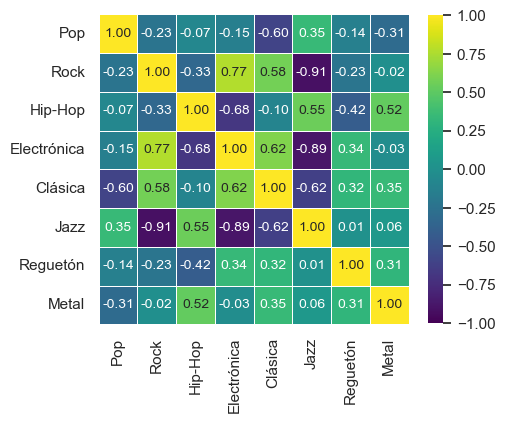

In [7]:
f, ax = plt.subplots(figsize=(5, 5))
corr = df.select_dtypes(include=['int64', 'float64']).corr()
sns.heatmap(corr, 
            cmap='viridis',                 # Mapa de colores 
            vmin=-1.0, 
            vmax=1.0, 
            square=True, 
            annot=True,                     # Muestra valores
            annot_kws={'size': 10},         # Tamaño de anotaciones
            fmt=".2f",                      # Formato decimal
            linewidths=0.5,                 # Ancho de líneas
            linecolor='white',              # Color de líneas
            cbar=True,                      # Barra de color
            cbar_kws={'shrink': 0.8},       # Tamaño de la barra
            ax=ax,)

OBSERVACIONES:
- Se puede ver que hay algunas relaciones lineales con valores altos como:
    - Rock y Jazz (Negativa)
    - Electronica y Jazz (Negativa)
    - Rock y Electronica (Positiva)
    - Electronica y Hip-Hop (Negativa)

# 2.- PREPARACIÓN Y ENTRENAMIENTO DE DATOS PARA MACHINE LEARNING

### 2.1.- TRANSFORMACIÓN DE DATOS

In [8]:
# Eliminando columna ID

df2 = df.copy()
df2 = df2.drop('País', axis=1)
#df2.head()

In [9]:
#Eliminando Outliers

#df2 = df.copy()
for col in df2.select_dtypes(include=['float64', 'int64']).columns:
    Q1 = df2[col].quantile(0.25)
    Q3 = df2[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df2 = df2[(df2[col] >= lower_bound) & (df2[col] <= upper_bound)]
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7 entries, 0 to 7
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Pop          7 non-null      int64
 1   Rock         7 non-null      int64
 2   Hip-Hop      7 non-null      int64
 3   Electrónica  7 non-null      int64
 4   Clásica      7 non-null      int64
 5   Jazz         7 non-null      int64
 6   Reguetón     7 non-null      int64
 7   Metal        7 non-null      int64
dtypes: int64(8)
memory usage: 504.0 bytes


### 2.2.- PREPARACIÓN DE DATAFRAME PARA ENTRENAMIENTO

In [10]:
# Normalizar datos

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df2)

### 2.3.- ENTRENAMIENTO DE MODELOS

#### -- MÉTODOS DE CLUSTERIZACIÓN --

#### a) K-Means:
- Evaluación K: Método "Silueta" y "Codo"
- Entrenamiento

c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _wina

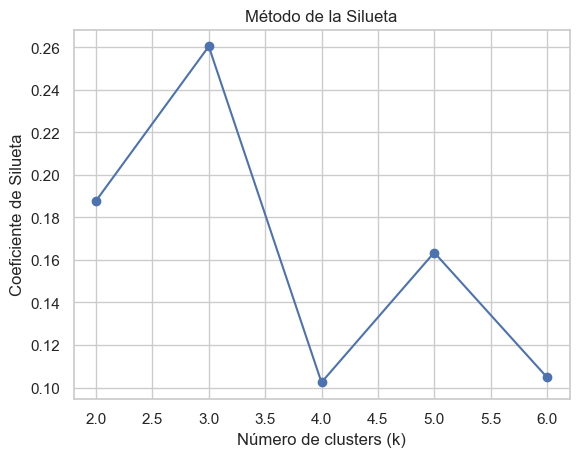

In [11]:
# Metodo de la silueta

silhouette_scores = []
for k in range(2,7):
    kmeans_sil = KMeans(n_clusters=k, random_state=99)
    labels_sil = kmeans_sil.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, labels_sil))

plt.plot(range(2,7), silhouette_scores, 'bo-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Coeficiente de Silueta')
plt.title('Método de la Silueta')
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

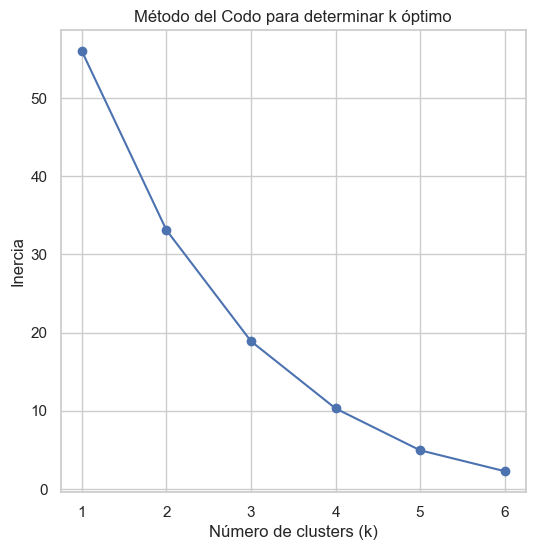

In [12]:
# Método del codo

inertia = []
k_range = range(1, 7) 

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=99, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Graficar
plt.figure(figsize=(6, 6))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para determinar k óptimo')
plt.xticks(k_range)
plt.grid(True)
plt.show()

OBSERVACION:
- Es mejor k=3 en ambos graficos
    - Silueta: Valor mayor
    - Codo: Mayor cambio en la pendiente

In [13]:
# Entrenando K-Means
kmeans = KMeans(n_clusters=3, random_state=99)
labels = kmeans.fit_predict(X_scaled)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


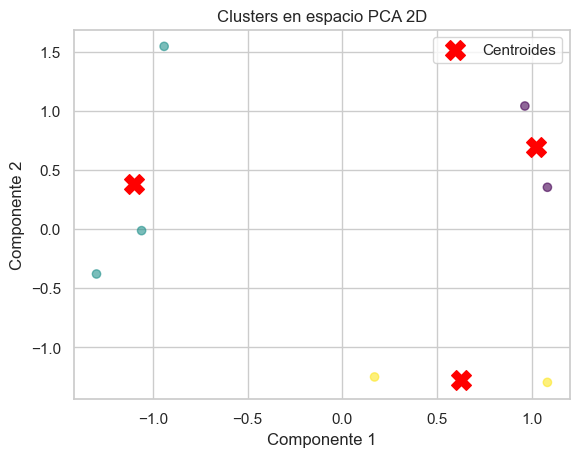

In [14]:
# Graficar
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Centroides')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.title('Clusters en espacio PCA 2D')
plt.legend()
plt.show()

#### b) Clustering jerárquico:
- Evaluación qty clusters mediante dendograma.

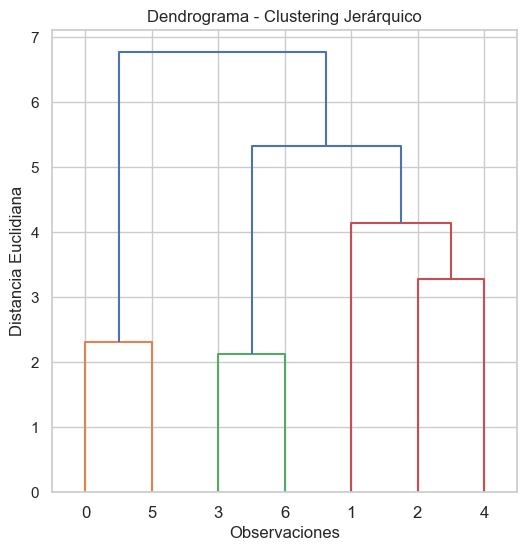

In [15]:
# Dendrograma
plt.figure(figsize=(6, 6))
dendrogram = sch.dendrogram(sch.linkage(X_scaled, method='ward'))
plt.title('Dendrograma - Clustering Jerárquico')
plt.xlabel('Observaciones')
plt.ylabel('Distancia Euclidiana')
plt.show()

OBSERVACION:
- Según dendograma k=4 es mejor

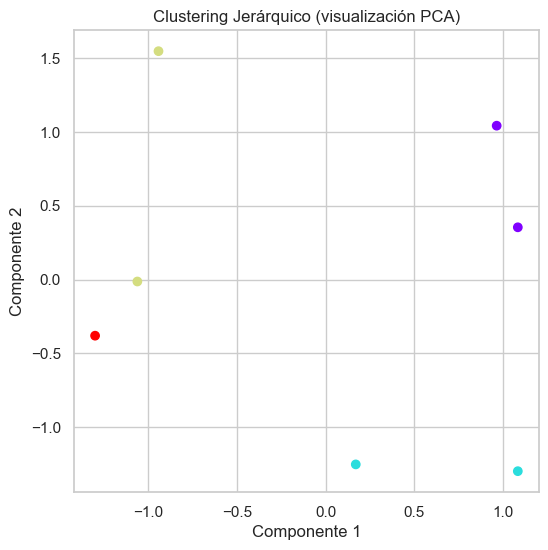

In [16]:
# Preparando clustering jerarquico

hc = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
y_hc = hc.fit_predict(X_scaled)

plt.figure(figsize=(6,6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_hc, cmap='rainbow')
plt.title('Clustering Jerárquico (visualización PCA)')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.show()

OBSERVACIÓN:
- Se puede ver que el cluster rojo y el amarillo son 2 clusters diferentes que podrian ser 1, Clusterizacion de K-Means es mas representativo

#### c) DBSCAN:
- Se probará con diferentes valores de eps y MinPts.

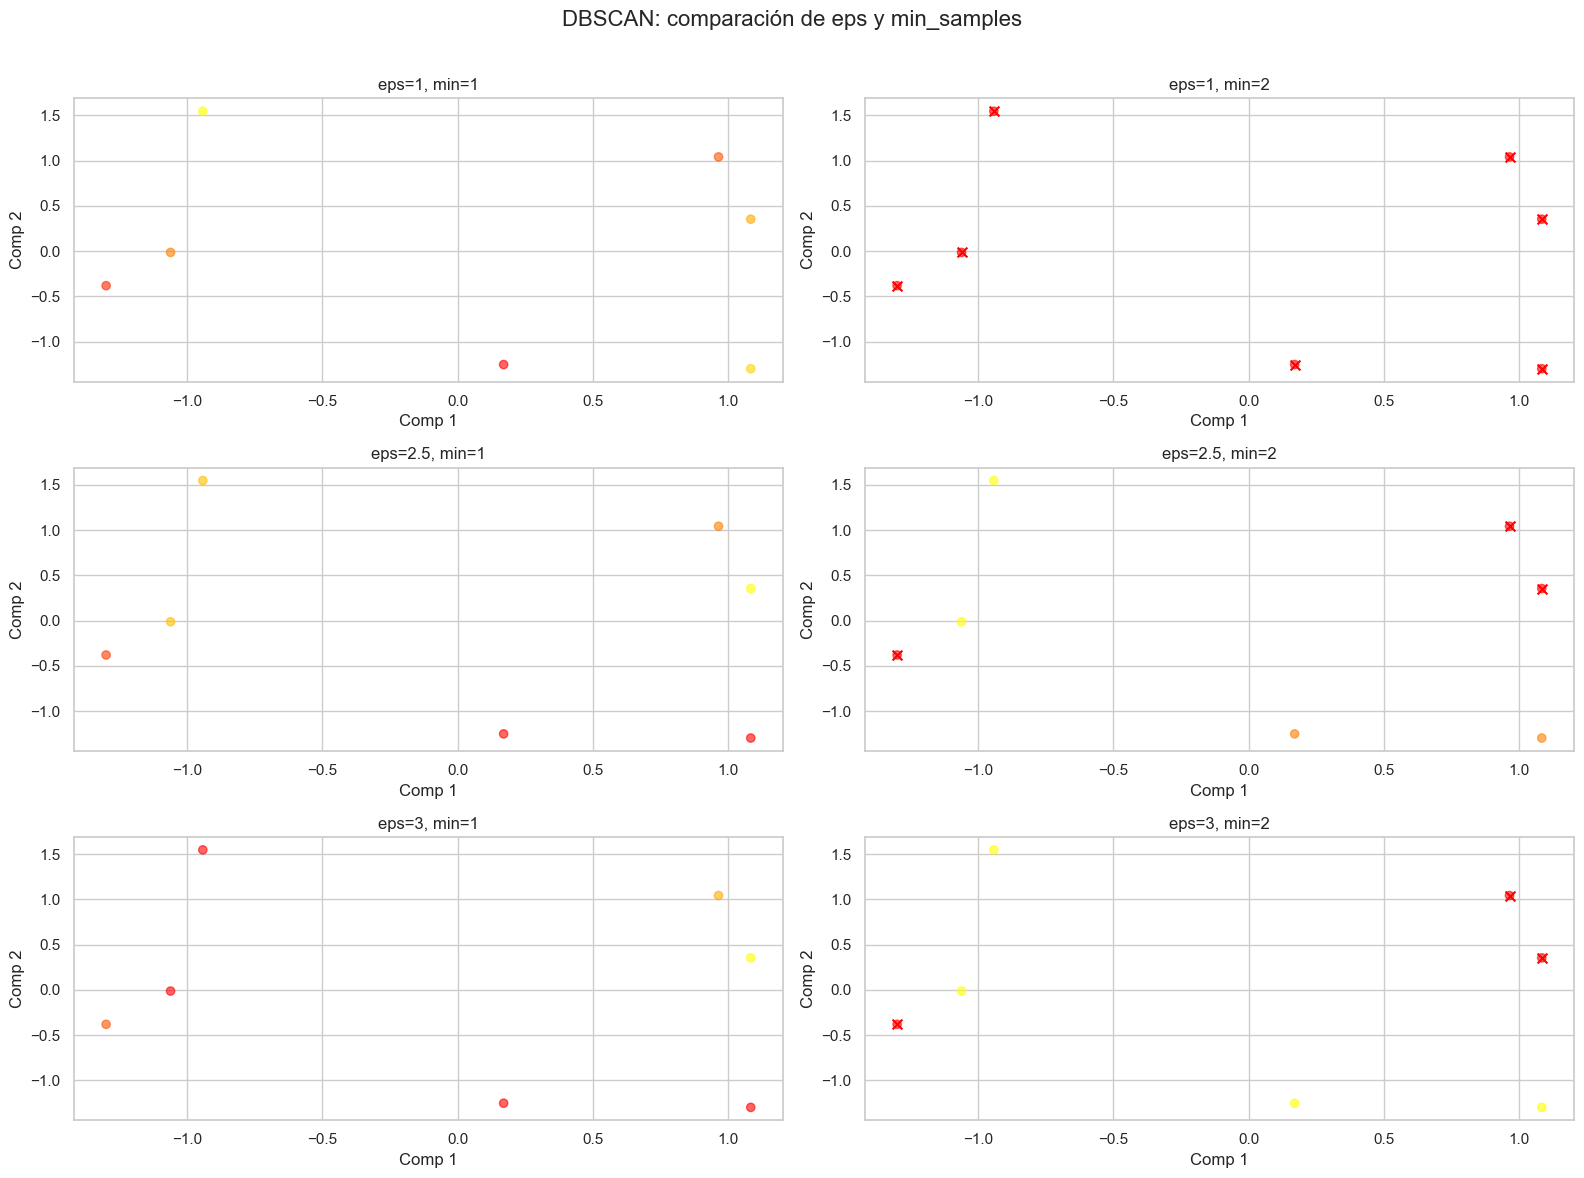

In [17]:
# Listas de parámetros
var_eps = [1, 2.5, 3]
var_min_samples = [1, 2]  

# Crear la grilla de subplots
fig, axes = plt.subplots(len(var_eps), len(var_min_samples), figsize=(16, 12))
fig.suptitle('DBSCAN: comparación de eps y min_samples', fontsize=16)

for row, eps in enumerate(var_eps):
    for col, min_samples in enumerate(var_min_samples):
        ax = axes[row, col]
        
        # Ajustar modelo
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)
        
        # Graficar
        scatter = ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='autumn', alpha=0.6)
        ax.scatter(X_scaled[labels == -1, 0], X_scaled[labels == -1, 1],
                   c='red', marker='x', s=50, label='Ruido')  # puntos -1 = ruido
        ax.set_title(f'eps={eps}, min={min_samples}')
        ax.set_xlabel('Comp 1')
        ax.set_ylabel('Comp 2')

plt.tight_layout(rect=[0, 0, 1, 0.97])  # Ajustar márgenes
plt.show()

OBSERVACIONES:
- eps: 2.5, min: 1 --> 3 cluster que no se superponen y no tienen outliers (Mejor)
- eps: 2.5, min: 2 --> 3 cluster que no se superponen pero si tienen outliers

#### -- MÉTODOS DE REDUCCIÓN DE DIMENSIONALIDAD --

#### d) PCA:
- Determinación de cuántos componentes principales explican al menos el 90% de la varianza.

In [18]:
# Aplicando PCA
pca = PCA(n_components=7)
label = pca.fit_transform(X_scaled)

# Calculando la varianza
varianza_acumulada = np.cumsum(pca.explained_variance_ratio_)

print(varianza_acumulada)

[0.47772364 0.77504055 0.91005801 0.9693864  0.98861194 1.
 1.        ]


OBSERVACION:
- Deberian haber 3 componentes principales para explicar al menos el 90% de la varianza

In [19]:
# preparando columna ID para incluirla, Eliminando Outliers

df3 = df.copy()
for col in df3.select_dtypes(include=['float64', 'int64']).columns:
    Q1 = df3[col].quantile(0.25)
    Q3 = df3[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df3 = df3[(df3[col] >= lower_bound) & (df3[col] <= upper_bound)]
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7 entries, 0 to 7
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   País         7 non-null      object
 1   Pop          7 non-null      int64 
 2   Rock         7 non-null      int64 
 3   Hip-Hop      7 non-null      int64 
 4   Electrónica  7 non-null      int64 
 5   Clásica      7 non-null      int64 
 6   Jazz         7 non-null      int64 
 7   Reguetón     7 non-null      int64 
 8   Metal        7 non-null      int64 
dtypes: int64(8), object(1)
memory usage: 560.0+ bytes


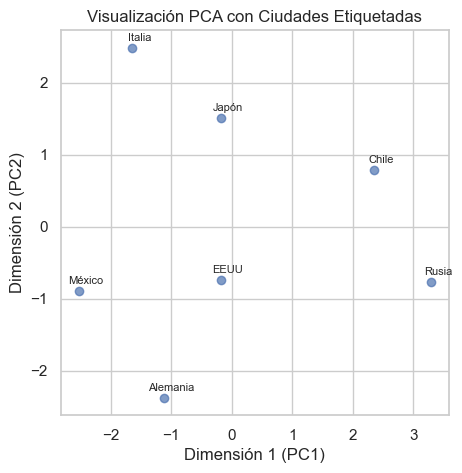

In [20]:
# Visualización 2D con PCA

pca2 = PCA(n_components=2)
label = pca2.fit_transform(X_scaled)

df_pca = pd.DataFrame(label, columns=['PC1', 'PC2'])
df_pca['País'] = df3['País'].values

plt.figure(figsize=(5, 5))
scatter = plt.scatter(df_pca['PC1'], df_pca['PC2'], alpha=0.7)

# Añadir etiquetas de ciudades
for i, ciudad in enumerate(df_pca['País']):
    plt.annotate(ciudad, (df_pca['PC1'][i], df_pca['PC2'][i]), 
                 textcoords="offset points", 
                 xytext=(5,5),  # Desplazamiento para evitar solapamiento
                 ha='center', 
                 fontsize=8)

plt.xlabel('Dimensión 1 (PC1)')
plt.ylabel('Dimensión 2 (PC2)')
plt.title('Visualización PCA con Ciudades Etiquetadas')
plt.grid(True)
plt.show()

#### e) t-SNE:
- Se experimentará con diferentes valores de perplexity.

In [21]:
# Aplicar t-SNE para reducción a 2D
tsne = TSNE(n_components=2, 
            random_state=99, 
            perplexity=3, 
            max_iter=1000,
            learning_rate=200)

X_tsne = tsne.fit_transform(X_scaled)

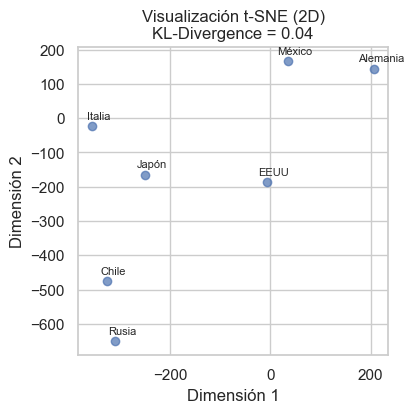

In [22]:
# Aplicando modelo t-SNE

# Creando df

df_tsne = pd.DataFrame(X_tsne, columns=['Dimensión 1', 'Dimensión 2'])
df_tsne['País'] = df3['País'].values

plt.figure(figsize=(4, 4))
scatter = plt.scatter(df_tsne['Dimensión 1'], df_tsne['Dimensión 2'], alpha=0.7)

# Añadir etiquetas
for i, ciudad in enumerate(df_tsne['País']):
    plt.annotate(ciudad, 
                 (df_tsne['Dimensión 1'][i], df_tsne['Dimensión 2'][i]),
                 textcoords="offset points",
                 xytext=(5, 5),  # Desplazamiento
                 ha='center',
                 fontsize=8)

plt.title(f'Visualización t-SNE (2D)\nKL-Divergence = {tsne.kl_divergence_:.2f}')
plt.xlabel('Dimensión 1')
plt.ylabel('Dimensión 2')
plt.grid(True)
plt.show()

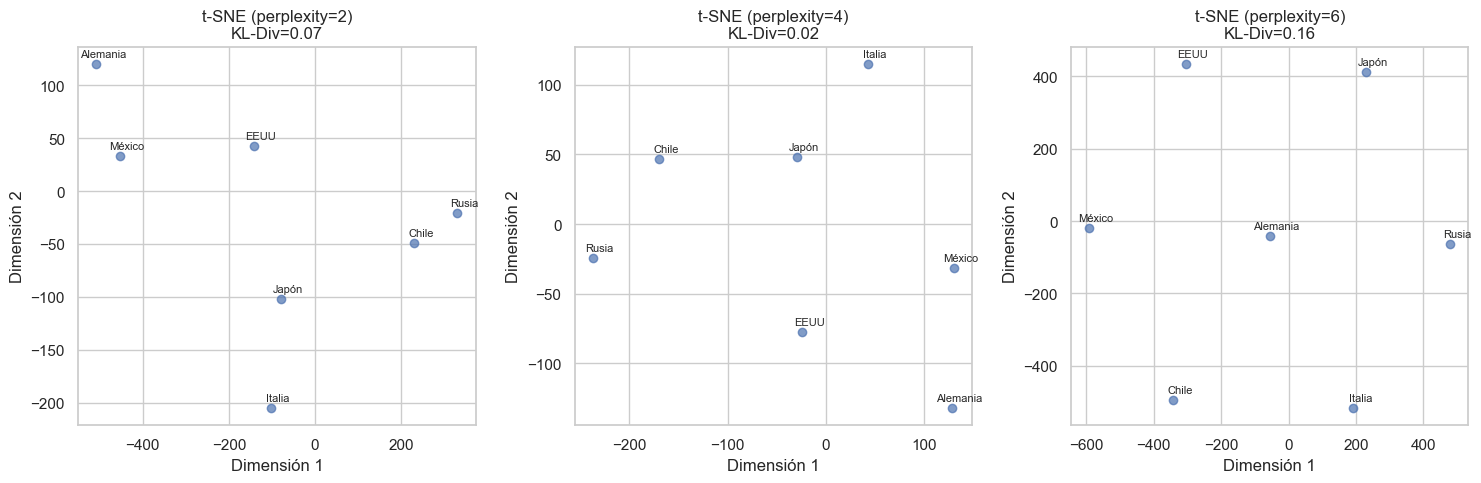

In [23]:
# Definir los valores de perplexity a probar
perplexities = [2, 4, 6]

# Crear figura con subplots
fig, axes = plt.subplots(1, len(perplexities), figsize=(5*len(perplexities), 5))

for idx, perp in enumerate(perplexities):
    tsne = TSNE(
        n_components=2,
        random_state=99,
        perplexity=perp,
        max_iter=1000,
        learning_rate=200
    )

    X_tsne = tsne.fit_transform(X_scaled)

    # Crear DataFrame
    df_tsne = pd.DataFrame(X_tsne, columns=['Dimensión 1', 'Dimensión 2'])
    df_tsne['País'] = df3['País'].values

    # Graficar
    ax = axes[idx]
    scatter = ax.scatter(df_tsne['Dimensión 1'], df_tsne['Dimensión 2'], alpha=0.7)

    # Añadir etiquetas
    for i, ciudad in enumerate(df_tsne['País']):
        ax.annotate(ciudad,
                    (df_tsne['Dimensión 1'][i], df_tsne['Dimensión 2'][i]),
                    textcoords="offset points",
                    xytext=(5, 5),
                    ha='center',
                    fontsize=8)

    ax.set_title(f't-SNE (perplexity={perp})\nKL-Div={tsne.kl_divergence_:.2f}')
    ax.set_xlabel('Dimensión 1')
    ax.set_ylabel('Dimensión 2')
    ax.grid(True)

plt.tight_layout()
plt.show()

OBSERVACIÓN:
- El mejor valor de perplexity encontrado es 4 ya que minimiza el KL-divergence lo que significa que la distribucion t-sne representa mejor a la distribucion original

# 3.- ANÁLISIS DE LOS RESULTADOS Y CONCLUSIONES

### 3.1.- COMPARACIÓN DE MÉTODOS:
- MODELOS DE CLUSTERIZACIÓN: El modelo K-Means explica de mejor forma la distribución, manteniendo clusters claros y alejados entre ellos, por lo que hace que su visualizacion sea mejor que los otros 2 modelos, esto se ve apoyado con las tecnicas de reducción PCA y t-sne donde se pueden evidenciar 3 cluster entre los paises.
- MODELOS DE REDUCCIÓN DIMENSIONAL: Dentro de las 2 tecnicas de reduccion dimensional, ambas tienen resultados similares visualizando 3 clusters sin problema, pero la que mejor permite visualizar la relacion entre paises es T-SNE ya que debido a su caracter no lineal y tendencia a preservar relaciones locales, podemos ver una distribucion un poco mas clara.

### 3.2.- INTERPRETACIÓN:
- Los datos representan que lo paises como: Chile y Rusia; Italia y Japon; USA, Mexico y Alemania son 3 grupos con culturas musicales similares, si bien son paises que se envuentran lejos entre ellos, estos resultados indican que si podria haber similitudes culturales independiente de su localizacion geografica.